<a href="https://colab.research.google.com/github/suryansh71234567/skin-disease-classification-using-custom-CNN/blob/main/suryansh_dsg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision

data preprocessing


In [ ]:
#!nvidia-smi
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:

!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset
!unzip skin-diseases-image-dataset.zip -d dataset/


In [ ]:
!unzip skin-diseases-image-dataset.zip -d dataset/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls dataset

In [ ]:
import os
import shutil


if not os.path.exists("dataset/IMG_CLASSES/"):
    print("Error: 'dataset/IMG_CLASSES/' directory not found.")
    print("Please make sure you have extracted the dataset correctly.")

base_dir = "dataset/IMG_CLASSES/"
target_dir = "dataset/labeled_data/"


os.makedirs(target_dir, exist_ok=True)


for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder.split(".")[0].strip()
        class_target_dir = os.path.join(target_dir, class_label)


        os.makedirs(class_target_dir, exist_ok=True)

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            if os.path.isfile(image_path):
                shutil.copy(image_path, class_target_dir)

print("Dataset restructured and labeled!")


In [ ]:
import os
import cv2
import numpy as np



img_size = (128, 128)
target_dir = "dataset/labeled_data/"
categories = os.listdir(target_dir)

images = []
labels = []


for label, class_name in enumerate(categories):
    class_path = os.path.join(target_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        if os.path.isfile(img_path):

            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0

            images.append(img)
            labels.append(label)



In [ ]:
import os


save_dir = '/content/drive/MyDrive/Colab Notebooks/image_data'
os.makedirs(save_dir, exist_ok=True)

images_path = os.path.join(save_dir, 'images.npy')
labels_path = os.path.join(save_dir, 'labels.npy')

## saving images and labels to google drive

In [ ]:
import numpy as np

np.save(images_path, images)
np.save(labels_path, labels)

In [ ]:
import os

images_path = '/content/drive/MyDrive/Colab Notebooks/image_data/images.npy'
labels_path = '/content/drive/MyDrive/Colab Notebooks/image_data/labels.npy'

In [ ]:
import numpy as np

images = np.load(images_path)
labels = np.load(labels_path)

fixing class imbalance

In [ ]:
import numpy as np


# Find indices of images with label 5
label_2_indices = np.where(labels == 2)[0]

# Randomly select 5k indices to remove
remove_indices = np.random.choice(label_2_indices, size=5500, replace=False)

# Remove the selected images and labels
images = np.delete(images, remove_indices, axis=0)
labels = np.delete(labels, remove_indices, axis=0)

print("Images and labels after removing 5k images from label 5:")
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images and labels after removing 5k images from label 5:
Images shape: (18330, 128, 128, 3)
Labels shape: (18330,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

# 1. Dataset Class
class SkinDiseaseDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]


        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm




img_size = 64
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm


X_train, X_val, Y_train, Y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_val = torch.tensor(Y_val, dtype=torch.long)

# Create PyTorch datasets
train_dataset = SkinDiseaseDataset(X_train, Y_train, transform=train_transform)
val_dataset = SkinDiseaseDataset(X_val, Y_val, transform=val_transform)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Data loaders created.")
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
# Create PyTorch datasets
train_dataset = SkinDiseaseDataset(X_train, Y_train, transform=train_transform)
val_dataset = SkinDiseaseDataset(X_val, Y_val, transform=val_transform)


Data loaders created.
Training data shape: (14664, 128, 128, 3)
Validation data shape: (3666, 128, 128, 3)


customizing resnet 50 for image classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, Bottleneck


class SEBlock(nn.Module):

    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class ModifiedBottleneck(Bottleneck):

    def __init__(self, *args, **kwargs):
        super(ModifiedBottleneck, self).__init__(*args, **kwargs)
        self.se = SEBlock(self.conv3.out_channels)

    def forward(self, x):
        out = super(ModifiedBottleneck, self).forward(x)
        out = self.se(out)
        return out


class SkinDiseaseResNet50(ResNet):

    def __init__(self, num_classes=10):
        super(SkinDiseaseResNet50, self).__init__(ModifiedBottleneck, [3, 4, 6, 3])

        # Replace initial 7x7 convolution with stacked 3x3 convolutions
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Reduce stride in the first convolutional layer of layer1
        self.layer1[0].conv2.stride = (1, 1)
        self.layer1[0].downsample[0].stride = (1, 1)

        # Add dilated convolutions in deeper layers
        for i in range(len(self.layer3)):
            self.layer3[i].conv2.dilation = (2, 2)
            self.layer3[i].conv2.padding = (2, 2)

        for i in range(len(self.layer4)):
            self.layer4[i].conv2.dilation = (4, 4)
            self.layer4[i].conv2.padding = (4, 4)

        # Final fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(512 * ModifiedBottleneck.expansion, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def skin_disease_resnet50(num_classes=10):
    """
    Create a modified ResNet-50 model for skin disease detection.
    """
    model = SkinDiseaseResNet50(num_classes=num_classes)
    return model


# Example usage
if __name__ == "__main__":
    model = skin_disease_resnet50(num_classes=5)
    print(model)

    # Test forward pass with a dummy input
    x = torch.randn(1, 3, 224, 224)
    y = model(x)
    print("Output shape:", y.shape)


SkinDiseaseResNet50(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ModifiedBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm





# 4. Define the Custom Model
class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()
        self.base_model = models.resnet50(weights = None)  # Train from scratch
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm





num_classes = 10
learning_rate = 0.001
num_epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet50(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 5. Training Loop
best_acc = 0.0
save_path = "custom_skin_disease_model.pth"

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            total_val += labels.size(0)



    val_loss /= total_val
    val_acc = val_corrects.double() / total_val
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    # Append metrics to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("Model saved!")

print("Training complete!")
print(f"Best Validation Accuracy: {best_acc:.4f}")

Epoch 1/25
--------------------


100%|██████████| 917/917 [00:53<00:00, 17.19it/s]

Train Loss: 1.9693, Train Acc: 0.2261


Val Loss: 1.7918, Val Acc: 0.2493
Model saved!
Epoch 2/25
--------------------


100%|██████████| 917/917 [00:52<00:00, 17.30it/s]

Train Loss: 1.8023, Train Acc: 0.2637


Val Loss: 1.7115, Val Acc: 0.2660
Model saved!
Epoch 3/25
--------------------


100%|██████████| 917/917 [00:54<00:00, 16.72it/s]

Train Loss: 1.7358, Train Acc: 0.2902


Val Loss: 1.5920, Val Acc: 0.3576
Model saved!
Epoch 4/25
--------------------


100%|██████████| 917/917 [00:56<00:00, 16.27it/s]

Train Loss: 1.6704, Train Acc: 0.3247


Val Loss: 1.5658, Val Acc: 0.3704
Model saved!
Epoch 5/25
--------------------


100%|██████████| 917/917 [00:58<00:00, 15.78it/s]

Train Loss: 1.6355, Train Acc: 0.3446


Val Loss: 1.5234, Val Acc: 0.3914
Model saved!
Epoch 6/25
--------------------


100%|██████████| 917/917 [00:53<00:00, 17.18it/s]

Train Loss: 1.5863, Train Acc: 0.3659


Val Loss: 1.4548, Val Acc: 0.4233
Model saved!
Epoch 7/25
--------------------


100%|██████████| 917/917 [00:57<00:00, 15.85it/s]

Train Loss: 1.5366, Train Acc: 0.3813


Val Loss: 1.4227, Val Acc: 0.4343
Model saved!
Epoch 8/25
--------------------


100%|██████████| 917/917 [01:04<00:00, 14.33it/s]

Train Loss: 1.5129, Train Acc: 0.3925


Val Loss: 1.3625, Val Acc: 0.4610
Model saved!
Epoch 9/25
--------------------


100%|██████████| 917/917 [01:04<00:00, 14.24it/s]

Train Loss: 1.4506, Train Acc: 0.4184


Val Loss: 1.3141, Val Acc: 0.4637
Model saved!
Epoch 10/25
--------------------


100%|██████████| 917/917 [00:56<00:00, 16.34it/s]

Train Loss: 1.4275, Train Acc: 0.4291


Val Loss: 1.2916, Val Acc: 0.4872
Model saved!
Epoch 11/25
--------------------


100%|██████████| 917/917 [01:05<00:00, 14.01it/s]

Train Loss: 1.4008, Train Acc: 0.4381


Val Loss: 1.2743, Val Acc: 0.4839
Epoch 12/25
--------------------


100%|██████████| 917/917 [01:00<00:00, 15.24it/s]

Train Loss: 1.3796, Train Acc: 0.4483


Val Loss: 1.2887, Val Acc: 0.4910
Model saved!
Epoch 13/25
--------------------


100%|██████████| 917/917 [00:53<00:00, 17.00it/s]

Train Loss: 1.3518, Train Acc: 0.4564


Val Loss: 1.2375, Val Acc: 0.4885
Epoch 14/25
--------------------


100%|██████████| 917/917 [01:01<00:00, 14.83it/s]

Train Loss: 1.3405, Train Acc: 0.4571


Val Loss: 1.2776, Val Acc: 0.4847
Epoch 15/25
--------------------


100%|██████████| 917/917 [00:53<00:00, 17.28it/s]

Train Loss: 1.3258, Train Acc: 0.4714


Val Loss: 1.2291, Val Acc: 0.5030
Model saved!
Epoch 16/25
--------------------


100%|██████████| 917/917 [00:54<00:00, 16.98it/s]

Train Loss: 1.3074, Train Acc: 0.4704


Val Loss: 1.2534, Val Acc: 0.4995
Epoch 17/25
--------------------


100%|██████████| 917/917 [00:55<00:00, 16.66it/s]

Train Loss: 1.2999, Train Acc: 0.4735


Val Loss: 1.2141, Val Acc: 0.5120
Model saved!
Epoch 18/25
--------------------


100%|██████████| 917/917 [00:54<00:00, 16.96it/s]

Train Loss: 1.2926, Train Acc: 0.4766


Val Loss: 1.1822, Val Acc: 0.5145
Model saved!
Epoch 19/25
--------------------


100%|██████████| 917/917 [00:52<00:00, 17.33it/s]

Train Loss: 1.2806, Train Acc: 0.4787


Val Loss: 1.1811, Val Acc: 0.5267
Model saved!
Epoch 20/25
--------------------


100%|██████████| 917/917 [00:53<00:00, 17.21it/s]

Train Loss: 1.2788, Train Acc: 0.4873


Val Loss: 1.1707, Val Acc: 0.5147
Epoch 21/25
--------------------


100%|██████████| 917/917 [00:54<00:00, 16.80it/s]


Train Loss: 1.2520, Train Acc: 0.4984
Val Loss: 1.1735, Val Acc: 0.5202
Epoch 22/25
--------------------


100%|██████████| 917/917 [00:51<00:00, 17.72it/s]

Train Loss: 1.2200, Train Acc: 0.5042


Val Loss: 1.1584, Val Acc: 0.5207
Epoch 23/25
--------------------


100%|██████████| 917/917 [00:51<00:00, 17.73it/s]

Train Loss: 1.2173, Train Acc: 0.5072


Val Loss: 1.1600, Val Acc: 0.5235
Epoch 24/25
--------------------


100%|██████████| 917/917 [00:54<00:00, 16.91it/s]

Train Loss: 1.2061, Train Acc: 0.5119


Val Loss: 1.1440, Val Acc: 0.5396
Model saved!
Epoch 25/25
--------------------


100%|██████████| 917/917 [00:52<00:00, 17.46it/s]

Train Loss: 1.1978, Train Acc: 0.5191


Val Loss: 1.1514, Val Acc: 0.5292
Training complete!
Best Validation Accuracy: 0.5396


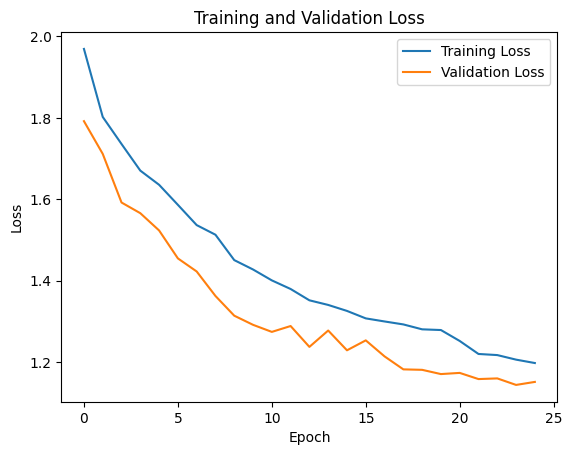

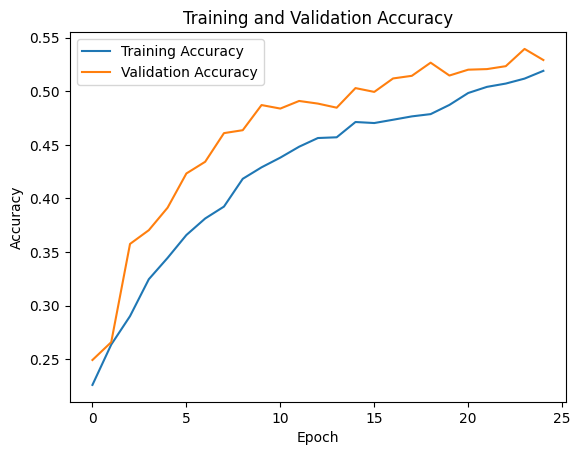

In [ ]:
import matplotlib.pyplot as plt

# 'train_loss', 'train_acc', 'val_loss', 'val_acc'
history = {
    'train_loss': train_losses,
    'train_acc': train_accuracies,
    'val_loss': val_losses,
    'val_acc': val_accuracies,
}


# Plot training and validation loss
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

training resnet 50 on the same dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

class CResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CResNet50, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.base_model(x)

# 5. Instantiate Model, Loss, and Optimizer
num_classes = 10
model = CResNet50(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Training Loop
num_epochs = 25
best_val_acc = 0.0
# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")


       # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = val_corrects.double() / total_val
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

      # Append metrics to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    if val_acc > best_val_acc:
        best_val_acc = val_acc

        torch.save(model.state_dict(), save_path)
        print("Model saved!")

print("Training complete!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

print("Training complete!")

history = {
    'train_loss': train_losses,
    'train_acc': train_accuracies,
    'val_loss': val_losses,
    'val_acc': val_accuracies,
}

Epoch 1/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.34it/s]

Train Loss: 1.6711, Train Acc: 0.3702


Val Loss: 1.4927, Val Acc: 0.4225
Model saved!
Epoch 2/25
--------------------


100%|██████████| 1833/1833 [01:26<00:00, 21.22it/s]

Train Loss: 1.3844, Train Acc: 0.4549


Val Loss: 1.2722, Val Acc: 0.4795
Model saved!
Epoch 3/25
--------------------


100%|██████████| 1833/1833 [01:28<00:00, 20.75it/s]

Train Loss: 1.2787, Train Acc: 0.4907


Val Loss: 1.2044, Val Acc: 0.5308
Model saved!
Epoch 4/25
--------------------


100%|██████████| 1833/1833 [01:26<00:00, 21.13it/s]

Train Loss: 1.2312, Train Acc: 0.5030


Val Loss: 1.1508, Val Acc: 0.5404
Model saved!
Epoch 5/25
--------------------


100%|██████████| 1833/1833 [01:26<00:00, 21.11it/s]

Train Loss: 1.1914, Train Acc: 0.5216


Val Loss: 1.1789, Val Acc: 0.5196
Epoch 6/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.42it/s]

Train Loss: 1.1652, Train Acc: 0.5361


Val Loss: 1.1142, Val Acc: 0.5565
Model saved!
Epoch 7/25
--------------------


100%|██████████| 1833/1833 [01:27<00:00, 20.87it/s]

Train Loss: 1.1386, Train Acc: 0.5475


Val Loss: 1.0810, Val Acc: 0.5701
Model saved!
Epoch 8/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.36it/s]

Train Loss: 1.1186, Train Acc: 0.5562


Val Loss: 1.0605, Val Acc: 0.5753
Model saved!
Epoch 9/25
--------------------


100%|██████████| 1833/1833 [01:26<00:00, 21.13it/s]

Train Loss: 1.0948, Train Acc: 0.5622


Val Loss: 1.0514, Val Acc: 0.5884
Model saved!
Epoch 10/25
--------------------


100%|██████████| 1833/1833 [01:23<00:00, 21.84it/s]

Train Loss: 1.0713, Train Acc: 0.5683


Val Loss: 1.0445, Val Acc: 0.5952
Model saved!
Epoch 11/25
--------------------


100%|██████████| 1833/1833 [01:24<00:00, 21.64it/s]

Train Loss: 1.0510, Train Acc: 0.5807


Val Loss: 1.0213, Val Acc: 0.5887
Epoch 12/25
--------------------


100%|██████████| 1833/1833 [01:22<00:00, 22.14it/s]

Train Loss: 1.0343, Train Acc: 0.5865


Val Loss: 1.0336, Val Acc: 0.5952
Epoch 13/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.32it/s]

Train Loss: 1.0141, Train Acc: 0.5980


Val Loss: 1.0208, Val Acc: 0.5993
Model saved!
Epoch 14/25
--------------------


100%|██████████| 1833/1833 [01:27<00:00, 21.02it/s]

Train Loss: 1.0020, Train Acc: 0.6007


Val Loss: 1.0466, Val Acc: 0.5925
Epoch 15/25
--------------------


100%|██████████| 1833/1833 [01:26<00:00, 21.10it/s]

Train Loss: 0.9849, Train Acc: 0.6148


Val Loss: 1.0099, Val Acc: 0.6140
Model saved!
Epoch 16/25
--------------------


100%|██████████| 1833/1833 [01:26<00:00, 21.30it/s]

Train Loss: 0.9640, Train Acc: 0.6183


Val Loss: 1.0019, Val Acc: 0.6107
Epoch 17/25
--------------------


100%|██████████| 1833/1833 [01:27<00:00, 21.01it/s]

Train Loss: 0.9479, Train Acc: 0.6261


Val Loss: 1.0015, Val Acc: 0.6167
Model saved!
Epoch 18/25
--------------------


100%|██████████| 1833/1833 [01:24<00:00, 21.75it/s]

Train Loss: 0.9212, Train Acc: 0.6377


Val Loss: 1.0312, Val Acc: 0.6113
Epoch 19/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.34it/s]

Train Loss: 0.9098, Train Acc: 0.6450


Val Loss: 0.9683, Val Acc: 0.6189
Model saved!
Epoch 20/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.43it/s]

Train Loss: 0.8926, Train Acc: 0.6520


Val Loss: 0.9988, Val Acc: 0.6206
Model saved!
Epoch 21/25
--------------------


100%|██████████| 1833/1833 [01:26<00:00, 21.11it/s]

Train Loss: 0.8719, Train Acc: 0.6613


Val Loss: 1.0116, Val Acc: 0.6203
Epoch 22/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.54it/s]

Train Loss: 0.8529, Train Acc: 0.6716


Val Loss: 0.9776, Val Acc: 0.6282
Model saved!
Epoch 23/25
--------------------


100%|██████████| 1833/1833 [01:27<00:00, 20.97it/s]

Train Loss: 0.8346, Train Acc: 0.6795


Val Loss: 1.0017, Val Acc: 0.6222
Epoch 24/25
--------------------


100%|██████████| 1833/1833 [01:24<00:00, 21.60it/s]

Train Loss: 0.8111, Train Acc: 0.6858


Val Loss: 1.0058, Val Acc: 0.6189
Epoch 25/25
--------------------


100%|██████████| 1833/1833 [01:25<00:00, 21.33it/s]

Train Loss: 0.7978, Train Acc: 0.6950


Val Loss: 0.9926, Val Acc: 0.6326
Model saved!
Training complete!
Best Validation Accuracy: 0.6326
Training complete!


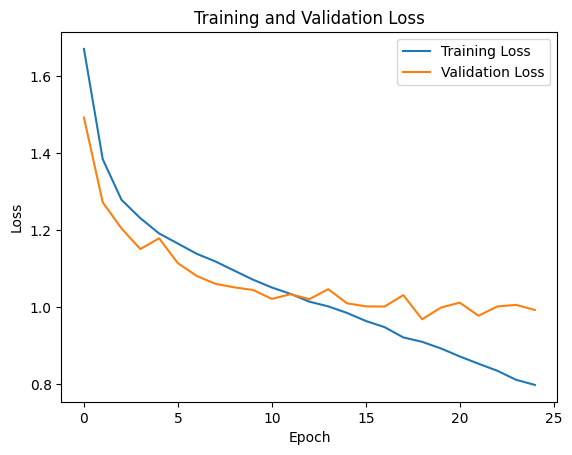

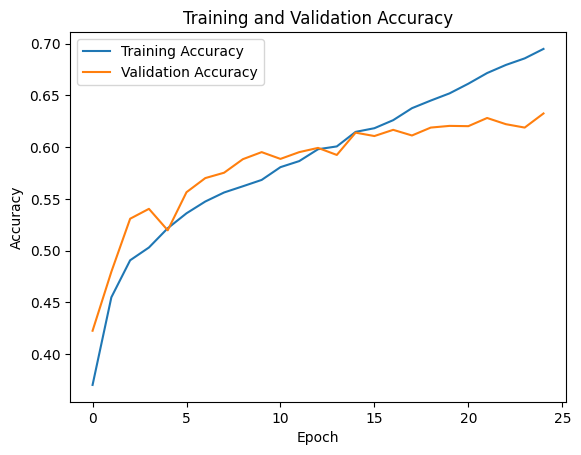

In [ ]:
import matplotlib.pyplot as plt

# 'train_loss', 'train_acc', 'val_loss', 'val_acc'

# Plot training and validation loss
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Making a custom CNN from scratch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the SE Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

# Define the CNN Model with SE Blocks
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.drop1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.25)

        self.se1 = SEBlock(64)
        self.se2 = SEBlock(128)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6272, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.drop4 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.se1(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.se2(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.drop3(x)


        x=self.flatten(x)
        x = self.fc1(x)
        x = F.relu(self.bn4(x))
        x = self.drop4(x)

        x = self.fc2(x)
        return x


In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

model = CustomCNN()
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         MaxPool2d-3           [-1, 32, 31, 31]               0
           Dropout-4           [-1, 32, 31, 31]               0
            Conv2d-5           [-1, 64, 31, 31]          18,496
            Conv2d-6           [-1, 64, 31, 31]          36,928
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                    [-1, 4]             256
              ReLU-9                    [-1, 4]               0
           Linear-10                   [-1, 64]             256
          Sigmoid-11                   [-1, 64]               0
          SEBlock-12           [-1, 64, 31, 31]               0
      BatchNorm2d-13           [-1, 64, 31, 31]             128
        MaxPool2d-14           [-1, 64,

Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm





num_classes = 10
learning_rate = 0.001
num_epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 5. Training Loop
best_acc = 0.0
save_path = "custom_skin_disease_model.pth"

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 20)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = val_corrects.double() / total_val
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("Model saved!")

print("Training complete!")
print(f"Best Validation Accuracy: {best_acc:.4f}")




Epoch 1/25
--------------------


100%|██████████| 1833/1833 [00:38<00:00, 47.78it/s]

Train Loss: 1.8717, Train Acc: 0.3138


Val Loss: 1.8056, Val Acc: 0.3631
Model saved!
Epoch 2/25
--------------------


100%|██████████| 1833/1833 [00:35<00:00, 52.12it/s]

Train Loss: 1.7029, Train Acc: 0.3656


Val Loss: 1.5612, Val Acc: 0.4034
Model saved!
Epoch 3/25
--------------------


100%|██████████| 1833/1833 [00:34<00:00, 53.12it/s]

Train Loss: 1.6032, Train Acc: 0.4008


Val Loss: 1.3865, Val Acc: 0.4594
Model saved!
Epoch 4/25
--------------------


100%|██████████| 1833/1833 [00:37<00:00, 49.23it/s]

Train Loss: 1.5307, Train Acc: 0.4212


Val Loss: 1.4184, Val Acc: 0.4536
Epoch 5/25
--------------------


100%|██████████| 1833/1833 [00:35<00:00, 51.66it/s]

Train Loss: 1.4862, Train Acc: 0.4392


Val Loss: 1.3266, Val Acc: 0.4932
Model saved!
Epoch 6/25
--------------------


100%|██████████| 1833/1833 [00:35<00:00, 51.74it/s]

Train Loss: 1.4462, Train Acc: 0.4462


Val Loss: 1.2529, Val Acc: 0.5210
Model saved!
Epoch 7/25
--------------------


100%|██████████| 1833/1833 [00:35<00:00, 52.13it/s]

Train Loss: 1.4173, Train Acc: 0.4609


Val Loss: 1.2716, Val Acc: 0.5131
Epoch 8/25
--------------------


100%|██████████| 1833/1833 [00:38<00:00, 48.01it/s]

Train Loss: 1.3931, Train Acc: 0.4659


Val Loss: 2.8984, Val Acc: 0.5218
Model saved!
Epoch 9/25
--------------------


100%|██████████| 1833/1833 [00:36<00:00, 50.79it/s]

Train Loss: 1.3721, Train Acc: 0.4793


Val Loss: 1.2750, Val Acc: 0.5188
Epoch 10/25
--------------------


100%|██████████| 1833/1833 [00:36<00:00, 50.52it/s]

Train Loss: 1.3451, Train Acc: 0.4916


Val Loss: 1.2005, Val Acc: 0.5352
Model saved!
Epoch 11/25
--------------------


100%|██████████| 1833/1833 [00:36<00:00, 49.65it/s]

Train Loss: 1.3176, Train Acc: 0.4968


Val Loss: 1.3309, Val Acc: 0.5510
Model saved!
Epoch 12/25
--------------------


100%|██████████| 1833/1833 [00:39<00:00, 45.87it/s]

Train Loss: 1.3099, Train Acc: 0.5001


Val Loss: 1.1575, Val Acc: 0.5652
Model saved!
Epoch 13/25
--------------------


100%|██████████| 1833/1833 [00:37<00:00, 48.57it/s]

Train Loss: 1.2854, Train Acc: 0.5059


Val Loss: 1.1588, Val Acc: 0.5701
Model saved!
Epoch 14/25
--------------------


100%|██████████| 1833/1833 [00:38<00:00, 48.12it/s]

Train Loss: 1.2745, Train Acc: 0.5072


Val Loss: 1.2419, Val Acc: 0.5559
Epoch 15/25
--------------------


100%|██████████| 1833/1833 [00:37<00:00, 48.67it/s]

Train Loss: 1.2560, Train Acc: 0.5166


Val Loss: 1.1177, Val Acc: 0.5589
Epoch 16/25
--------------------


100%|██████████| 1833/1833 [00:40<00:00, 45.23it/s]

Train Loss: 1.2433, Train Acc: 0.5248


Val Loss: 1.1005, Val Acc: 0.5723
Model saved!
Epoch 17/25
--------------------


100%|██████████| 1833/1833 [00:38<00:00, 47.98it/s]

Train Loss: 1.2271, Train Acc: 0.5346


Val Loss: 1.0965, Val Acc: 0.5739
Model saved!
Epoch 18/25
--------------------


100%|██████████| 1833/1833 [00:39<00:00, 45.89it/s]

Train Loss: 1.2236, Train Acc: 0.5331


Val Loss: 1.0888, Val Acc: 0.5837
Model saved!
Epoch 19/25
--------------------


100%|██████████| 1833/1833 [00:38<00:00, 47.84it/s]

Train Loss: 1.2100, Train Acc: 0.5357


Val Loss: 1.0791, Val Acc: 0.5780
Epoch 20/25
--------------------


100%|██████████| 1833/1833 [00:38<00:00, 47.76it/s]

Train Loss: 1.2009, Train Acc: 0.5356


Val Loss: 1.0650, Val Acc: 0.5857
Model saved!
Epoch 21/25
--------------------


100%|██████████| 1833/1833 [00:37<00:00, 49.11it/s]

Train Loss: 1.1899, Train Acc: 0.5422


Val Loss: 1.0546, Val Acc: 0.5960
Model saved!
Epoch 22/25
--------------------


100%|██████████| 1833/1833 [00:37<00:00, 49.21it/s]

Train Loss: 1.1751, Train Acc: 0.5536


Val Loss: 1.0618, Val Acc: 0.5957
Epoch 23/25
--------------------


100%|██████████| 1833/1833 [00:39<00:00, 46.45it/s]

Train Loss: 1.1739, Train Acc: 0.5466


Val Loss: 1.0564, Val Acc: 0.5947
Epoch 24/25
--------------------


100%|██████████| 1833/1833 [00:39<00:00, 45.85it/s]

Train Loss: 1.1598, Train Acc: 0.5504


Val Loss: 1.0298, Val Acc: 0.6047
Model saved!
Epoch 25/25
--------------------


100%|██████████| 1833/1833 [00:42<00:00, 43.62it/s]

Train Loss: 1.1561, Train Acc: 0.5556


Val Loss: 1.0313, Val Acc: 0.6039
Training complete!
Best Validation Accuracy: 0.6047


In [ ]:
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the saved model
save_path = '/content/drive/MyDrive/Colab Notebooks/my_model_customresnet_25epoch.pth'
model = CustomResNet50(num_classes=num_classes).to(device)

if os.path.exists(save_path):

    checkpoint = torch.load(save_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded saved model from:", save_path)
else:
    print("Saved model not found. Starting training from scratch.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


best_acc = 0.0
num_epochs = 30

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = val_corrects.double() / total_val
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("Model saved!")

print("Training complete!")
print(f"Best Validation Accuracy: {best_acc:.4f}")




<ipython-input-17-9f470ee18923>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


Loaded saved model from: /content/drive/MyDrive/Colab Notebooks/my_model_customresnet_25epoch.pth
Epoch 1/30


100%|██████████| 917/917 [00:52<00:00, 17.33it/s]


Train Loss: 1.1882, Train Acc: 0.5226
Val Loss: 1.1362, Val Acc: 0.5300
Model saved!
Epoch 2/30


100%|██████████| 917/917 [00:54<00:00, 16.76it/s]

Train Loss: 1.1778, Train Acc: 0.5255


Val Loss: 1.1714, Val Acc: 0.5464
Model saved!
Epoch 3/30


100%|██████████| 917/917 [00:55<00:00, 16.54it/s]

Train Loss: 1.1606, Train Acc: 0.5299


Val Loss: 1.1233, Val Acc: 0.5273
Epoch 4/30


100%|██████████| 917/917 [00:52<00:00, 17.39it/s]

Train Loss: 1.1633, Train Acc: 0.5291


Val Loss: 1.1148, Val Acc: 0.5357
Epoch 5/30


100%|██████████| 917/917 [00:52<00:00, 17.45it/s]

Train Loss: 1.1578, Train Acc: 0.5346


Val Loss: 1.1332, Val Acc: 0.5338
Epoch 6/30


100%|██████████| 917/917 [00:52<00:00, 17.53it/s]

Train Loss: 1.1393, Train Acc: 0.5337


Val Loss: 1.1278, Val Acc: 0.5423
Epoch 7/30


100%|██████████| 917/917 [00:54<00:00, 16.80it/s]

Train Loss: 1.1328, Train Acc: 0.5409


Val Loss: 1.1261, Val Acc: 0.5368
Epoch 8/30


100%|██████████| 917/917 [00:53<00:00, 17.26it/s]

Train Loss: 1.1224, Train Acc: 0.5473


Val Loss: 1.1237, Val Acc: 0.5466
Model saved!
Epoch 9/30


100%|██████████| 917/917 [00:54<00:00, 16.89it/s]

Train Loss: 1.1263, Train Acc: 0.5402


Val Loss: 1.1041, Val Acc: 0.5496
Model saved!
Epoch 10/30


100%|██████████| 917/917 [00:53<00:00, 17.06it/s]

Train Loss: 1.1257, Train Acc: 0.5475


Val Loss: 1.0858, Val Acc: 0.5597
Model saved!
Epoch 11/30


100%|██████████| 917/917 [00:55<00:00, 16.43it/s]

Train Loss: 1.1180, Train Acc: 0.5514


Val Loss: 1.0997, Val Acc: 0.5554
Epoch 12/30


100%|██████████| 917/917 [00:55<00:00, 16.59it/s]

Train Loss: 1.0957, Train Acc: 0.5564


Val Loss: 1.1005, Val Acc: 0.5526
Epoch 13/30


100%|██████████| 917/917 [00:53<00:00, 17.01it/s]

Train Loss: 1.0984, Train Acc: 0.5584


Val Loss: 1.1073, Val Acc: 0.5595
Epoch 14/30


100%|██████████| 917/917 [00:53<00:00, 17.04it/s]

Train Loss: 1.0887, Train Acc: 0.5630


Val Loss: 1.0964, Val Acc: 0.5576
Epoch 15/30


100%|██████████| 917/917 [00:53<00:00, 17.12it/s]

Train Loss: 1.0866, Train Acc: 0.5653


Val Loss: 1.0973, Val Acc: 0.5565
Epoch 16/30


100%|██████████| 917/917 [00:55<00:00, 16.61it/s]

Train Loss: 1.0616, Train Acc: 0.5724


Val Loss: 1.0920, Val Acc: 0.5679
Model saved!
Epoch 17/30


100%|██████████| 917/917 [00:55<00:00, 16.61it/s]

Train Loss: 1.0761, Train Acc: 0.5698


Val Loss: 1.0692, Val Acc: 0.5712
Model saved!
Epoch 18/30


100%|██████████| 917/917 [00:54<00:00, 16.94it/s]

Train Loss: 1.0455, Train Acc: 0.5765


Val Loss: 1.0707, Val Acc: 0.5731
Model saved!
Epoch 19/30


100%|██████████| 917/917 [00:53<00:00, 17.20it/s]

Train Loss: 1.0583, Train Acc: 0.5755


Val Loss: 1.0742, Val Acc: 0.5693
Epoch 20/30


100%|██████████| 917/917 [00:53<00:00, 17.02it/s]

Train Loss: 1.0471, Train Acc: 0.5805


Val Loss: 1.0724, Val Acc: 0.5797
Model saved!
Epoch 21/30


100%|██████████| 917/917 [00:54<00:00, 16.86it/s]

Train Loss: 1.0402, Train Acc: 0.5819


Val Loss: 1.0517, Val Acc: 0.5802
Model saved!
Epoch 22/30


100%|██████████| 917/917 [00:54<00:00, 16.68it/s]

Train Loss: 1.0315, Train Acc: 0.5867


Val Loss: 1.0873, Val Acc: 0.5794
Epoch 23/30


100%|██████████| 917/917 [00:53<00:00, 17.11it/s]

Train Loss: 1.0192, Train Acc: 0.5920


Val Loss: 1.1098, Val Acc: 0.5546
Epoch 24/30


100%|██████████| 917/917 [00:52<00:00, 17.32it/s]

Train Loss: 1.0370, Train Acc: 0.5882


Val Loss: 1.0747, Val Acc: 0.5777
Epoch 25/30


100%|██████████| 917/917 [00:52<00:00, 17.34it/s]

Train Loss: 0.9981, Train Acc: 0.6026


Val Loss: 1.0662, Val Acc: 0.5851
Model saved!
Epoch 26/30


100%|██████████| 917/917 [00:54<00:00, 16.73it/s]

Train Loss: 0.9964, Train Acc: 0.5982


Val Loss: 1.0252, Val Acc: 0.5922
Model saved!
Epoch 27/30


100%|██████████| 917/917 [00:55<00:00, 16.44it/s]

Train Loss: 0.9911, Train Acc: 0.6081


Val Loss: 1.0570, Val Acc: 0.5979
Model saved!
Epoch 28/30


100%|██████████| 917/917 [00:53<00:00, 17.10it/s]

Train Loss: 0.9743, Train Acc: 0.6117


Val Loss: 1.0420, Val Acc: 0.5947
Epoch 29/30


100%|██████████| 917/917 [00:53<00:00, 17.14it/s]

Train Loss: 0.9715, Train Acc: 0.6136


Val Loss: 1.0769, Val Acc: 0.5843
Epoch 30/30


100%|██████████| 917/917 [00:52<00:00, 17.40it/s]

Train Loss: 0.9642, Train Acc: 0.6178


Val Loss: 1.0628, Val Acc: 0.5857
Training complete!
Best Validation Accuracy: 0.5979


Saving model in google drive

In [ ]:
# Saving
save_path = '/content/drive/MyDrive/Colab Notebooks/my_model_customresnet_25epoch.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),

}, save_path)

# Loading
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



<ipython-input-15-d2178aab4518>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


while writing the code many times all the information in the ram is lost due to runtime error and to cope with this I have written the code in such a way that I have to rerun lesser amount of code after runtime error. And this is the reason why I have imported many things again and again in every block of code.
Also the code for saving the trained model is usable and I have saved all three models reusing the same code while changing the path name.